In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import pandas as pd
import scipy.stats
import sklearn.datasets
import sklearn.preprocessing

%matplotlib notebook

#plt.xkcd()

None

# Singular Value Decomposition for Data Visualization

## Displaying high-dimensional data using reduced-rank matrices

A data visualization goes a long way in helping you understand the underlying dataset. If the data is highly dimensional, you can use Singular Value Decomposition (SVD) to find a reduced-rank approximation of the data that can be visualized easily.

## Example: the Iris dataset

We start off with the [Iris flower dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set). The data is multivariate, with 150 measurements of 4 features (length and width cm of both sepal and petal) on 3 distinct Iris species. Of the 150 measurements, there are 50 measurements each for _Iris setosa_, _Iris versicolor_, and _Iris virginica_.

[Scikit Learn's `datasets`](http://scikit-learn.org/stable/datasets/) includes the Iris dataset, so let's load that up and start exploring.

In [2]:
iris = sklearn.datasets.load_iris()

df_iris = pd.DataFrame(iris.data, columns=iris.feature_names)

print('Iris dataset has {} rows and {} columns\n'.format(*df_iris.shape))

print('Here are the first 5 rows of the data:\n\n{}\n'.format(df_iris.head(5)))

print('Some simple statistics on the Iris dataset:\n\n{}\n'.format(df_iris.describe()))

Iris dataset has 150 rows and 4 columns

Here are the first 5 rows of the data:

   sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2

Some simple statistics on the Iris dataset:

       sepal length (cm)  sepal width (cm)  petal length (cm)  \
count         150.000000        150.000000         150.000000   
mean            5.843333          3.057333           3.758000   
std             0.828066          0.435866           1.765298   
min             4.300000          2.000000           1.000000   
25%             5.100000          2.800000           1.600000   
50%             5.800000   

As we are exploring the dataset, it would be nice to view the data in order to get an idea of how the 3 species might be distributed with respect to one another in terms of their features. Perhaps we are interested in finding clusters, or maybe we would like to find a way to make class predictions?

However, since the data has 4 dimensions, we would be hard-pressed to come up with a good way to graph the data in 4D that we could easily understand.

_But what if we could reduce or compress the data so that we could work in 3 dimensions or less?_

[Singular value decomposition](http://mathworld.wolfram.com/SingularValueDecomposition.html) lets us do just that.

## Singular value decomposition

Singular value decomposition factorizes an $\mathbb{R}^{m \times n}$ matrix $X$ into

* matrix $U \in \mathbb{R}^{m \times m}$ are the left-singular vectors of $X$, where columns are the set of orthonormal eigenvectors of $X \, X^{\intercal}$
* diagonal matrix $\Sigma$ with entries $\sigma \in \mathbb{R}$ that are the non-negative singular values of $X$
* matrix $V \in \mathbb{R}^{n \times n}$ are the right-singular vectors $X$, where the columns are the set of orthonormal eigenvectors of $X^{\intercal} \, X$

such that 

\begin{align}
  X &= U \, \Sigma \, V^{\intercal}
\end{align}

We can use [`numpy.linalg.svd`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.svd.html) to factorize the Iris data matrix into three components $U$, $\Sigma$, and $V^{\intercal}$.

In [3]:
U_iris, S_iris, Vt_iris = np.linalg.svd(df_iris, full_matrices=False)

#### $U$: left-singular vectors of $X$

The rows of the $U$ correspond to the rows of original data matrix $X$, while the columns are the set of ordered, orthornormal eigenvectors of $X \, X^{\intercal}$.

In [4]:
print('matrix U has {} rows, {} columns\n'.format(*U_iris.shape))
print('here are the first 5 rows.')

print('{}'.format(pd.DataFrame(U_iris).head(5)))

matrix U has 150 rows, 4 columns

here are the first 5 rows.
          0         1         2         3
0 -0.061617  0.129611  0.002139  0.001638
1 -0.058071  0.111020  0.070672  0.051757
2 -0.056763  0.117966  0.004343  0.009557
3 -0.056653  0.105308  0.005925 -0.041644
4 -0.061230  0.131090 -0.031881 -0.032215


#### $V$: right-singular vectors of $X$

[`numpy.linalg.svd`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.svd.html) actually returns $V^{\intercal}$ instead of $V$, so it is the _columns_ of $V^{\intercal}$ that correspond to the columns of original data matrix $X$. Hence, the _rows_ are the set of ordered, orthornormal eigenvectors of $X^{\intercal} \, X$.

In [5]:
print('matrix Vt has {} rows, {} columns\n'.format(*Vt_iris.shape))

print('{}'.format(pd.DataFrame(Vt_iris).head()))

matrix Vt has 4 rows, 4 columns

          0         1         2         3
0 -0.751108 -0.380086 -0.513009 -0.167908
1  0.284175  0.546745 -0.708665 -0.343671
2  0.502155 -0.675243 -0.059166 -0.537016
3  0.320814 -0.317256 -0.480745  0.751872


#### $\Sigma$: singular values of $X$

The elements $\sigma_{i}$ of diagonal matrix $\Sigma$ are the non-zero singular values of matrix $X$, which are really just the square roots of the non-zero eigenvalues of $X^{\intercal} \, X$ (and also for $X \, X^{\intercal}$). These singular values can be used to determine the amount of variance $X^{\prime}$ explains of the original data matrix $X$ when reducing the dimensions to find a lower rank approximation.

\begin{align}
   X^{\prime}_{k} &=  U_{k} \, \Sigma_{k} \, V^{\intercal}_{k} \\
                           &\approx X_{r} & \text{ where } rank(X^{\prime}) = k \lt rank(X) = r
\end{align}

The amount of variance that the reduced rank approximation $X^{\prime}_{k}$ explains of $X_{r}$ is

\begin{align}
  \text{cum. variance explained} &= \frac{\sum_{j=1}^{k} \sigma_{j}^{2}}{\sum_{i=1}^{r} \sigma_{i}^{2}}
\end{align}

**NOTE**: [`numpy.linalg.svd`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.svd.html) actually returns a $\Sigma$ that is not a diagonal _matrix_, but a _list_ of the entries on the diagonal.

In [6]:
num_sv_iris = np.arange(1, S_iris.size+1)

cum_var_explained_iris = [np.sum(np.square(S_iris[0:n])) / np.sum(np.square(S_iris)) for n in num_sv_iris]

Let's have a look at the cumulative variance explained visually as a function of the number of singular values used when reducing rank to find a lower-ranked matrix $X^{\prime}$ to approximate $X$. This will inform us as to how many dimensions we should use.

<IPython.core.display.Javascript object>


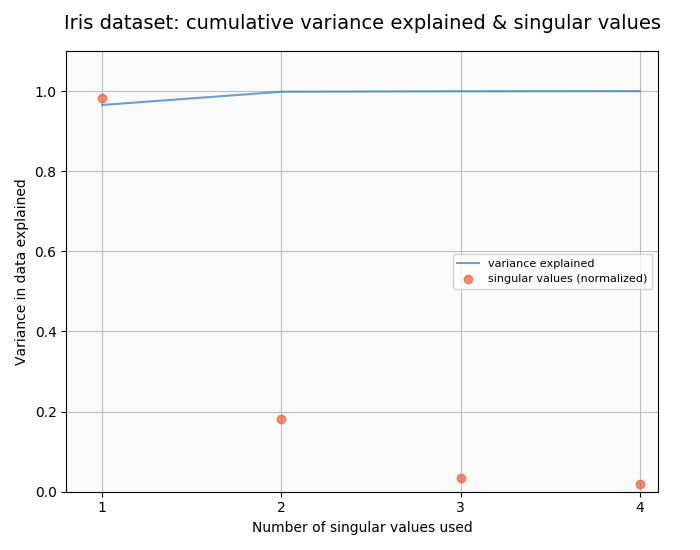

In [7]:
fig = plt.figure(figsize=(7.0,5.5))
ax = fig.add_subplot(111)

plt.plot(num_sv_iris,
         cum_var_explained_iris,
         color='#2171b5',
         label='variance explained',
         alpha=0.65,
         zorder=1000)

plt.scatter(num_sv_iris,
            sklearn.preprocessing.normalize(S_iris.reshape((1,-1))),
            color='#fc4e2a',
            label='singular values (normalized)',
            alpha=0.65,
            zorder=1000)

plt.legend(loc='center right', scatterpoints=1, fontsize=8)

ax.set_xticks(num_sv_iris)
ax.set_xlim(0.8, 4.1)
ax.set_ylim(0.0, 1.1)
ax.set_xlabel(r'Number of singular values used')
ax.set_ylabel('Variance in data explained')
ax.set_title('Iris dataset: cumulative variance explained & singular values',
             fontsize=14,
             y=1.03)

ax.set_facecolor('0.98')

plt.grid(alpha=0.8, zorder=1)
plt.tight_layout()

#### Dimension reduction

Judging from the curve representing cumulative variance explained in the figure above, we can see that

* with 1 singular value, about 96.5% of the variance of $X$ can be explained
* with 2 singular values, that number goes up to approximately 99.8%

Since graphing the Iris dataset in 1D wouldn't be all that interesting (just dots on a line segment), let's try using the first 2 singular values to represent the data on the $x$- and $y$-axes, respectively.

In [8]:
# the iris.target gives the actual labels for the data points
# we're just selecting the locations corresponding to data points labeled 0,1,2 resp
# then we can plot those using different colors.

idx_setosa = np.where(iris.target==0)[0]
idx_versicolor = np.where(iris.target==1)[0]
idx_virginica = np.where(iris.target==2)[0]

setosa_x = U_iris[idx_setosa, 0]
setosa_y = U_iris[idx_setosa, 1]

print(setosa_x.shape)

versicolor_x = U_iris[idx_versicolor, 0]
versicolor_y = U_iris[idx_versicolor, 1]

virginica_x = U_iris[idx_virginica, 0]
virginica_y = U_iris[idx_virginica, 1]

(50,)


Let's do a 1-d plot first. Note that I am using the x-coordinate for both the axes below.

<IPython.core.display.Javascript object>


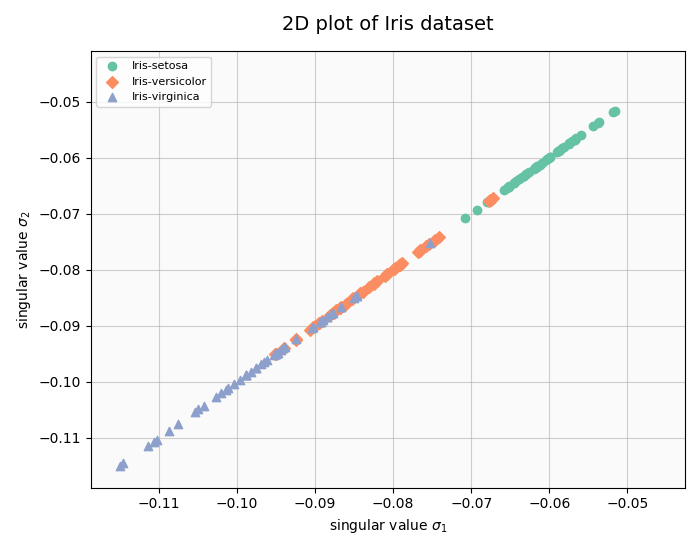

In [9]:
fig = plt.figure(figsize=(7.0,5.5))
ax = fig.add_subplot(111)

plt.scatter(setosa_x,
            setosa_x,
            marker='o',
            color='#66c2a5',
            label='Iris-setosa',
            zorder=1000)

plt.scatter(versicolor_x,
            versicolor_x,
            marker='D',
            color='#fc8d62',
            label='Iris-versicolor',
            zorder=1000)

plt.scatter(virginica_x,
            virginica_x,
            marker='^',
            color='#8da0cb',
            label='Iris-virginica',
            zorder=1000)

plt.legend(loc='upper left', scatterpoints=1, fontsize=8)

ax.set_xlabel(r'singular value $\sigma_{1}$')
ax.set_ylabel(r'singular value $\sigma_{2}$')
ax.set_title('2D plot of Iris dataset',
             fontsize=14,
             y=1.03)
ax.set_facecolor('0.98')

plt.grid(alpha=0.6, zorder=1)
plt.tight_layout()

Even the first principal direction (the first singular vector) gives a pretty good representation of the data, the three clusters are quite visible, and there's a clear separation between the first and last clusters.

Now we represent the three Iris species on a 2D graph.

<IPython.core.display.Javascript object>


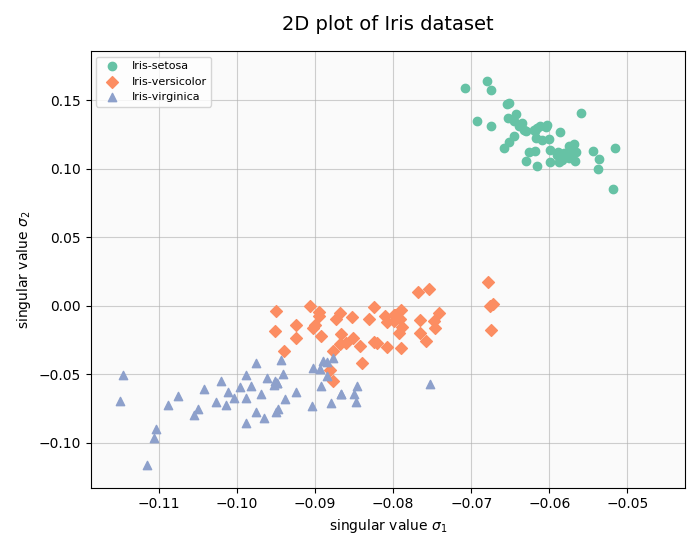

In [10]:
fig = plt.figure(figsize=(7.0,5.5))
ax = fig.add_subplot(111)

plt.scatter(setosa_x,
            setosa_y,
            marker='o',
            color='#66c2a5',
            label='Iris-setosa',
            zorder=1000)

plt.scatter(versicolor_x,
            versicolor_y,
            marker='D',
            color='#fc8d62',
            label='Iris-versicolor',
            zorder=1000)

plt.scatter(virginica_x,
            virginica_y,
            marker='^',
            color='#8da0cb',
            label='Iris-virginica',
            zorder=1000)

plt.legend(loc='upper left', scatterpoints=1, fontsize=8)

ax.set_xlabel(r'singular value $\sigma_{1}$')
ax.set_ylabel(r'singular value $\sigma_{2}$')
ax.set_title('2D plot of Iris dataset',
             fontsize=14,
             y=1.03)
ax.set_facecolor('0.98')

plt.grid(alpha=0.6, zorder=1)
plt.tight_layout()

There!

Now that we are viewing the originally 4D data with 2 dimensions using the first 2 singular value columns of the $U$ left singular vectors matrix, we can see that there should be a very clear separation for the _Iris setosa_ class and the others. On the other hand, the demarcation between _Iris versicolor_ and _Iris virginica_ might not be as clear cut.

Nevertheless, since this 2D reduced-rank matrix representation $X^{\prime}$ explains nearly 99.8% of the variance in the original dataset, we can be pretty certain that clustering and classification should be possible.

---

One more thing to mention: we used the first few columns of $U$ (i.e., the left singular vectors) instead of projecting the data points onto the right singular vectors. But remember that the left singular vectors were formed by projecting the data onto V, and then scaling coordinates: $U = XV \Sigma^{-1}$. So doing the actual projections would only rescale coordinates. Let's test this out (and check out the scale of the axes is now different):

<IPython.core.display.Javascript object>


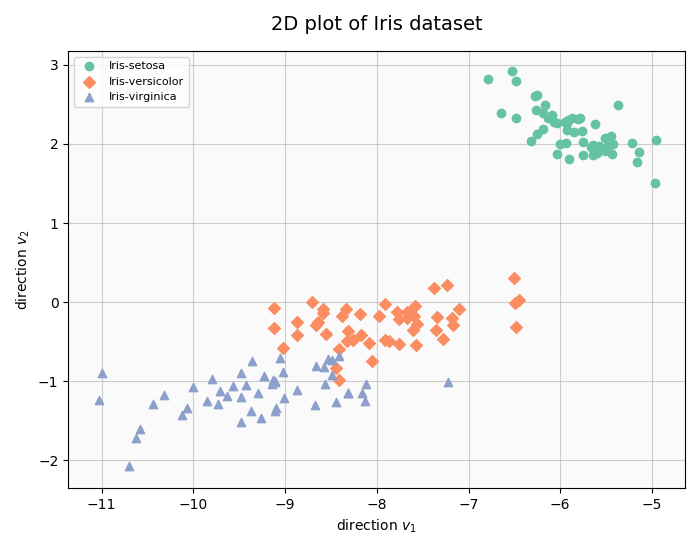

In [11]:
# Projecting the data onto the right singular vectors
P_iris = df_iris.to_numpy().dot(Vt_iris.T)

#and this is the same code as above
idx_setosa = np.where(iris.target==0)[0]
idx_versicolor = np.where(iris.target==1)[0]
idx_virginica = np.where(iris.target==2)[0]

setosa_x = P_iris[idx_setosa, 0]
setosa_y = P_iris[idx_setosa, 1]

versicolor_x = P_iris[idx_versicolor, 0]
versicolor_y = P_iris[idx_versicolor, 1]

virginica_x = P_iris[idx_virginica, 0]
virginica_y = P_iris[idx_virginica, 1]

fig = plt.figure(figsize=(7.0,5.5))
ax = fig.add_subplot(111)

plt.scatter(setosa_x,
            setosa_y,
            marker='o',
            color='#66c2a5',
            label='Iris-setosa',
            zorder=1000)

plt.scatter(versicolor_x,
            versicolor_y,
            marker='D',
            color='#fc8d62',
            label='Iris-versicolor',
            zorder=1000)

plt.scatter(virginica_x,
            virginica_y,
            marker='^',
            color='#8da0cb',
            label='Iris-virginica',
            zorder=1000)

plt.legend(loc='upper left', scatterpoints=1, fontsize=8)

ax.set_xlabel(r'direction $v_{1}$')
ax.set_ylabel(r'direction $v_{2}$')
ax.set_title('2D plot of Iris dataset',
             fontsize=14,
             y=1.03)
ax.set_facecolor('0.98')

plt.grid(alpha=0.6, zorder=1)
plt.tight_layout()

---

# Appendix A

## PCA and SVD

Principal components analysis (PCA) and singular value decomposition are closely related, and you may often hear both these terms used in the same breath.  

Here is a quick mathematical treatment explaining how PCA and SVD are related.

Consider data matrix $X \in \mathbb{R}^{m \times n}$ where $m > n$, and all $x_{ij}$ are centered about the column means. With principal components analysis, we have

\begin{align}
  \text{covariance matrix } C &= \frac{1}{m} \, X^{\intercal} \, X & \text{from PCA} \\
  &= \frac{1}{m} \, V \, \Gamma \, V^{\intercal} & \text{by eigendecomposition of } X^{\intercal} \, X \\
  \\
  \text{ but } X &= U \, \Sigma V^{\intercal} & \text{from SVD} \\
  \\
  \Rightarrow C &= \frac{1}{m} \, V \, \Sigma \, U^{\intercal} \, U \, \Sigma V^{\intercal} \\
  &= \frac{1}{m} \, V \, \Sigma^{2} \, V^{\intercal} \\
\end{align}

So we see that:

1. the singular values in $\Sigma$ obtained via SVD are really just the square roots of the eigenvalues in $\Gamma$ of the covariance matrix in PCA.
1. if you mean-center your raw data matrix $X$ and then calculate SVD, you are doing the same thing as PCA.
1. the above example shows covariance of $X$ with respect to its columns ($X^{\intercal} \, X$); it also applies for covariance of $X$ with respect to rows ($X \, X^{\intercal}$).

#### Iris dataset: PCA & SVD

In [12]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(iris.data)

# don't forget to mean-center the data before SVD
X = iris.data - np.mean(iris.data, axis=0)
U, S, Vt = np.linalg.svd(X)

#### Compare the eigenvalues of $\Gamma$ derived from PCA with the singular values from $\Sigma$ derived with SVD: $\Gamma = \Sigma^{2}$?

In [13]:
Cov_pca = pca.get_covariance()

print('eigenvalues from PCA:\n{}\n'.format(np.linalg.eigvals(Cov_pca * X.shape[0])))

print('squared singular values from SVD:\n{}'.format(np.square(S)))

eigenvalues from PCA:
[634.23625591  36.40061219  11.73142501   3.57526395]

squared singular values from SVD:
[630.0080142   36.15794144  11.65321551   3.55142885]


#### Can we obtain the covariance matrix $C$ derived with PCA, but using  $\frac{1}{m} \, V \, \Sigma^{2} \, V^{\intercal}$ from SVD?

In [14]:
print('covariance matrix C derived from PCA:\n{}\n'.format(Cov_pca))

Cov_svd = (1. / X.shape[0]) * Vt.T.dot(np.diag(np.square(S))).dot(Vt) 
print('covariance matrix using S and Vt from SVD:\n{}\n'.format(Cov_svd))

allclose = np.allclose(Cov_pca, Cov_svd, atol=1e-1)
print('Are these matrices equivalent (element-wise closeness comparison)?\n{}'.format(allclose))

covariance matrix C derived from PCA:
[[ 0.68569351 -0.042434    1.27431544  0.51627069]
 [-0.042434    0.18997942 -0.32965638 -0.12163937]
 [ 1.27431544 -0.32965638  3.11627785  1.2956094 ]
 [ 0.51627069 -0.12163937  1.2956094   0.58100626]]

covariance matrix using S and Vt from SVD:
[[ 0.68112222 -0.04215111  1.26582     0.51282889]
 [-0.04215111  0.18871289 -0.32745867 -0.12082844]
 [ 1.26582    -0.32745867  3.09550267  1.286972  ]
 [ 0.51282889 -0.12082844  1.286972    0.57713289]]

Are these matrices equivalent (element-wise closeness comparison)?
True
